## Spain: Electricity Mix

In [58]:
import json, pandas as pd
from pathlib import Path

In [60]:

# Paths to the two Spanish generation‑mix JSON files
files = [
    Path("..") / "data" / "generation_data" / "gen_SP_1.json",
    Path("..") / "data" / "generation_data" / "gen_SP_2.json",
]

rows = []
for fp in files:
    with open(fp, "r", encoding="utf-8") as f:
        js = json.load(f)

    # Each technology is in `included`; its daily series is under attributes → values
    for tech in js.get("included", []):
        tech_name = tech["attributes"]["title"]  # e.g. "Hidráulica"
        for v in tech["attributes"].get("values", []):
            rows.append(
                {
                    "datetime": v["datetime"][:10],  # keep date part YYYY‑MM‑DD
                    "technology": tech_name,
                    "value": v["value"],
                }
            )

# Long → wide
df_long = pd.DataFrame(rows)
df_long["datetime"] = pd.to_datetime(df_long["datetime"])

df_wide = (
    df_long.pivot_table(
        index="datetime", columns="technology", values="value", aggfunc="sum"
    )
    .sort_index()
)

df_wide.reset_index(inplace=True)
df_wide.head()


technology,datetime,Carbón,Ciclo combinado,Cogeneración,Eólica,Fuel + Gas,Generación total,Hidroeólica,Hidráulica,Motores diésel,Nuclear,Otras renovables,Residuos no renovables,Residuos renovables,Solar fotovoltaica,Solar térmica,Turbina de gas,Turbina de vapor
0,2021-05-21,10704.287,73001.855,74625.031,155894.865,NaN,644980.744,143.171,73883.825,5279.083,119965.517,12369.130,5130.6420,1018.6720,83705.870,25501.607,870.342,2886.847
1,2021-05-22,10774.967,66884.692,70269.685,127623.325,NaN,589408.240,140.081,77443.693,4888.217,120171.870,13214.733,5166.8165,1005.4995,72179.886,16774.223,827.658,2042.894
2,2021-05-23,11510.497,71942.040,69718.071,128453.671,NaN,549018.679,134.624,55731.601,4809.192,120347.046,13563.270,5146.5330,1043.2990,50523.534,13002.416,967.950,2124.935
3,2021-05-24,16967.108,54120.475,73956.059,182665.421,NaN,646010.515,140.599,63902.700,5541.004,120062.731,13433.646,5164.7735,1006.8415,83806.643,22112.340,925.268,2204.906
4,2021-05-25,17693.930,82573.520,74239.310,141667.500,NaN,647615.565,142.516,68739.725,5671.966,120118.612,13251.959,5367.5240,1023.0020,87685.132,26520.215,738.709,2181.945


In [62]:

min_date, max_date = df_wide["datetime"].min().date().isoformat(), df_wide["datetime"].max().date().isoformat()
print(min_date,  max_date)

2021-05-21 2025-04-30


In [63]:

# --- guardar ----------------------------------------------------
out_path = Path("..") / "data" / "generation_data" / f"eco2mix_SP_daily_{min_date}_{max_date}.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
df_wide.to_csv(out_path, index=False, encoding="utf-8")
df_wide = df_wide.reset_index(drop = True)

print("CSV diario guardado en:", out_path.resolve())
df_wide.head()

CSV diario guardado en: C:\Users\frolo\Documentos\PythonProjects\volatility-spillovers\data\generation_data\eco2mix_SP_daily_2021-05-21_2025-04-30.csv


technology,datetime,Carbón,Ciclo combinado,Cogeneración,Eólica,Fuel + Gas,Generación total,Hidroeólica,Hidráulica,Motores diésel,Nuclear,Otras renovables,Residuos no renovables,Residuos renovables,Solar fotovoltaica,Solar térmica,Turbina de gas,Turbina de vapor
0,2021-05-21,10704.287,73001.855,74625.031,155894.865,NaN,644980.744,143.171,73883.825,5279.083,119965.517,12369.130,5130.6420,1018.6720,83705.870,25501.607,870.342,2886.847
1,2021-05-22,10774.967,66884.692,70269.685,127623.325,NaN,589408.240,140.081,77443.693,4888.217,120171.870,13214.733,5166.8165,1005.4995,72179.886,16774.223,827.658,2042.894
2,2021-05-23,11510.497,71942.040,69718.071,128453.671,NaN,549018.679,134.624,55731.601,4809.192,120347.046,13563.270,5146.5330,1043.2990,50523.534,13002.416,967.950,2124.935
3,2021-05-24,16967.108,54120.475,73956.059,182665.421,NaN,646010.515,140.599,63902.700,5541.004,120062.731,13433.646,5164.7735,1006.8415,83806.643,22112.340,925.268,2204.906
4,2021-05-25,17693.930,82573.520,74239.310,141667.500,NaN,647615.565,142.516,68739.725,5671.966,120118.612,13251.959,5367.5240,1023.0020,87685.132,26520.215,738.709,2181.945


## Portugal: Electricity Mix

In [67]:
# Imports and API


import requests, time, json
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm   
import matplotlib.pyplot as plt
from requests.adapters import HTTPAdapter, Retry
from pathlib import Path



%matplotlib inline



In [68]:
API = ("https://servicebus.ren.pt/datahubapi/electricity/"
       "ElectricityConsumptionSupplyDaily")

# ▶️ sesión con reintentos exponenciales
def make_session(retries=5, backoff=0.5) -> requests.Session:
    retry = Retry(
        total=retries,             # nº máx. de reintentos
        backoff_factor=backoff,    # 0.5 → 0.5s, 1s, 2s, 4s…
        status_forcelist=[500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    sess = requests.Session()
    sess.mount("https://", adapter)
    return sess

session = make_session()

def fetch_day(date_str, culture="pt-PT", read_timeout=60):
    url = f"{API}?culture={culture}&date={date_str}"
    r = session.get(url, timeout=(10, read_timeout))  # 10 s para conectar, 60 s para leer
    r.raise_for_status()
    data = r.json()
    if not data or isinstance(data, dict):
        return None
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(date_str)
    return df

In [70]:
start = datetime(2021, 5, 21)
end   = datetime(2025, 4, 30)

frames = []
for day in tqdm(list(pd.date_range(start, end)), desc="Descargando"):
    df = fetch_day(day.strftime("%Y-%m-%d"))
    if df is not None:
        frames.append(df)
    time.sleep(0.3)   # evita sobrecargar el servidor

consumo_raw = pd.concat(frames, ignore_index=True)
print(f"{len(consumo_raw)} filas descargadas.")



Descargando:   0%|          | 0/1441 [00:00<?, ?it/s]

36242 filas descargadas.


In [73]:
pivot = consumo_raw.pivot_table(index="date",
                                columns="type",
                                values="daily_Accumulation",
                                aggfunc="sum").fillna(0)

pivot.head()          # primera vista


type,BIOMASSA,BIOMASSA_COGERACAO,BIOMASSA_OUTROS,CARVAO,CONSUMO,CONSUMO_ARMAZENAMENTO,CONSUMO_BATERIAS,CONSUMO_BOMBAGEM,CORRIGIDO_TEMPERATURA,EOLICA,...,OUTRA_TERMICA,OUTRA_TERMICA_COGERACAO,OUTRA_TERMICA_OUTROS,PRODUCAO_ARMAZENAMENTO,PRODUCAO_BOMBAGEM,PRODUCAO_NAO_RENOVAVEL,PRODUCAO_RENOVAVEL,PRODUCAO_TOTAL,SALDO_IMPORTADOR,SOLAR
date,,,,,,,,,,,,,,,,,,,,,
2021-05-21,10.0,5.0,5.0,0.0,133.0,5.0,0.0,5.0,133.0,45.0,...,1.0,0.0,1.0,6.0,6.0,42.0,71.0,119.0,19.0,6.0
2021-05-22,10.0,5.0,5.0,0.0,117.0,5.0,0.0,5.0,117.0,49.0,...,1.0,0.0,1.0,5.0,5.0,10.0,80.0,95.0,27.0,5.0
2021-05-23,9.0,5.0,5.0,0.0,108.0,13.0,0.0,13.0,108.0,59.0,...,1.0,0.0,1.0,2.0,2.0,8.0,84.0,95.0,27.0,7.0
2021-05-24,9.0,4.0,5.0,0.0,129.0,13.0,0.0,13.0,129.0,47.0,...,1.0,0.0,1.0,5.0,5.0,22.0,77.0,104.0,38.0,5.0
2021-05-25,8.0,3.0,5.0,0.0,133.0,0.0,0.0,0.0,133.0,35.0,...,1.0,0.0,1.0,10.0,10.0,44.0,68.0,123.0,10.0,6.0


In [74]:
# build the path one level up, inside data/generation_data
out_path = Path("..") / "data" / "generation_data"
out_path.mkdir(parents=True, exist_ok=True)   # creates ../data/generation_data/

pivot.reset_index(inplace=True)


pivot.to_csv(out_path / "consumo_PT_2021-05-21_2023-04-30.csv",
             encoding="utf-8",
             index=False)

pivot.head()

type,date,BIOMASSA,BIOMASSA_COGERACAO,BIOMASSA_OUTROS,CARVAO,CONSUMO,CONSUMO_ARMAZENAMENTO,CONSUMO_BATERIAS,CONSUMO_BOMBAGEM,CORRIGIDO_TEMPERATURA,...,OUTRA_TERMICA,OUTRA_TERMICA_COGERACAO,OUTRA_TERMICA_OUTROS,PRODUCAO_ARMAZENAMENTO,PRODUCAO_BOMBAGEM,PRODUCAO_NAO_RENOVAVEL,PRODUCAO_RENOVAVEL,PRODUCAO_TOTAL,SALDO_IMPORTADOR,SOLAR
0,2021-05-21,10.0,5.0,5.0,0.0,133.0,5.0,0.0,5.0,133.0,...,1.0,0.0,1.0,6.0,6.0,42.0,71.0,119.0,19.0,6.0
1,2021-05-22,10.0,5.0,5.0,0.0,117.0,5.0,0.0,5.0,117.0,...,1.0,0.0,1.0,5.0,5.0,10.0,80.0,95.0,27.0,5.0
2,2021-05-23,9.0,5.0,5.0,0.0,108.0,13.0,0.0,13.0,108.0,...,1.0,0.0,1.0,2.0,2.0,8.0,84.0,95.0,27.0,7.0
3,2021-05-24,9.0,4.0,5.0,0.0,129.0,13.0,0.0,13.0,129.0,...,1.0,0.0,1.0,5.0,5.0,22.0,77.0,104.0,38.0,5.0
4,2021-05-25,8.0,3.0,5.0,0.0,133.0,0.0,0.0,0.0,133.0,...,1.0,0.0,1.0,10.0,10.0,44.0,68.0,123.0,10.0,6.0


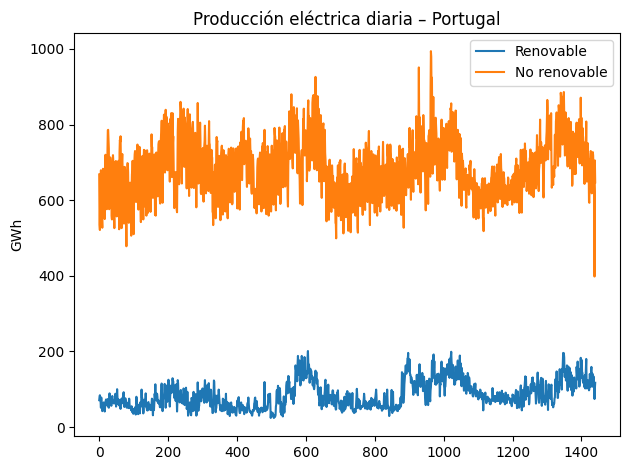

In [76]:
# Ejemplo: pila apilada de producción renovable vs. no renovable
ren = ["EOLICA", "HIDRICA", "SOLAR", "BIOMASSA"]
non_ren = [c for c in pivot.columns if c not in ren and c not in ['date']]

pivot[ren].sum(axis=1).plot(label="Renovable")
pivot[non_ren].sum(axis=1).plot(label="No renovable")
plt.title("Producción eléctrica diaria – Portugal")
plt.ylabel("GWh")
plt.legend()
plt.tight_layout()
plt.show()

## France: Electricity Mix

In [1]:
import requests, pprint, json, pandas as pd, datetime as dt
from tqdm.notebook import tqdm
import datetime as dt
import numpy as np
import pathlib as Path

In [2]:
BASE = "https://odre.opendatasoft.com/api/v2/catalog/datasets"
DATASET = "eco2mix-national-cons-def"

FIELDS = [
    "date_heure",          # marca de tiempo
    "consommation",        # carga total
    # Renovables
    "eolien",
    "solaire",
    # Hidráulica (suma de sub-tipos más abajo)
    "hydraulique_fil_eau_eclusee",
    "hydraulique_lacs",
    "hydraulique_step_turbinage",
    # Fósiles
    "gaz_tac", "gaz_cogen", "gaz_ccg", "gaz_autres",
    "fioul_tac", "fioul_cogen", "fioul_autres",
    "charbon",
    # Nuclear
    "nucleaire",
    # Bioenergías
    "bioenergies_dechets", "bioenergies_biogaz", "bioenergies_biomasse",
    # Intercambios y CO₂ (opcional)
    "ech_physiques", "taux_co2"
]



In [3]:
# ───────────────────────── helpers ──────────────────────────
def api_records(params, timeout=60):
    """Devuelve lista de dicts con los 'fields'."""
    url = f"{BASE}/{DATASET}/records"
    r   = requests.get(url, params=params, timeout=timeout)
    js  = r.json()
    if r.status_code != 200 or "error" in js:
        raise RuntimeError(f"[{r.status_code}] {js.get('error', js)}")
    # 'records' → cada elem. → 'record' → 'fields'
    return [rec["record"]["fields"] for rec in js.get("records", [])]


def dataset_bounds():
    earliest = api_records({"select":"date_heure",
                            "order_by":"date_heure", "limit":1})[0]["date_heure"]
    latest   = api_records({"select":"date_heure",
                            "order_by":"date_heure desc", "limit":1})[0]["date_heure"]
    return earliest, latest


def fetch_interval(start_iso, end_iso, batch=100, pbar=None):
    rows, offset = [], 0
    while True:
        page = api_records({
            "select": ",".join(FIELDS),
            "where": f"date_heure >= '{start_iso}' AND date_heure < '{end_iso}'",
            "order_by": "date_heure",
            "limit": batch,
            "offset": offset,
            "timezone": "Europe/Paris"
        })
        if not page:
            if offset == 0:
                print(f"⚠️ sin filas {start_iso}→{end_iso}")
            break
        rows.extend(page)
        offset += batch
        if pbar:
            pbar.update(len(page))
        if len(page) < batch:
            break
    return pd.DataFrame(rows)

In [4]:
t0, t1 = dt.date(2021, 5, 21), dt.date(2025, 4, 30)
step   = dt.timedelta(days=31)

frames = []
for cur in tqdm(pd.date_range(t0, t1, freq="MS"), desc="Meses", unit="mes"):
    nxt = min(cur.date()+step, t1+dt.timedelta(days=1))
    with tqdm(total=0, desc=str(cur.date()), unit="rows", leave=False) as pb:
        df = fetch_interval(cur.date().isoformat(), nxt.isoformat(), batch=100, pbar=pb)
    if not df.empty:
        frames.append(df)

raw = pd.concat(frames, ignore_index=True)
print("Total filas descargadas:", len(raw))

Meses:   0%|          | 0/47 [00:00<?, ?mes/s]

2021-06-01: 0rows [00:00, ?rows/s]

2021-07-01: 0rows [00:00, ?rows/s]

2021-08-01: 0rows [00:00, ?rows/s]

2021-09-01: 0rows [00:00, ?rows/s]

2021-10-01: 0rows [00:00, ?rows/s]

2021-11-01: 0rows [00:00, ?rows/s]

2021-12-01: 0rows [00:00, ?rows/s]

2022-01-01: 0rows [00:00, ?rows/s]

2022-02-01: 0rows [00:00, ?rows/s]

2022-03-01: 0rows [00:00, ?rows/s]

2022-04-01: 0rows [00:00, ?rows/s]

2022-05-01: 0rows [00:00, ?rows/s]

2022-06-01: 0rows [00:00, ?rows/s]

2022-07-01: 0rows [00:00, ?rows/s]

2022-08-01: 0rows [00:00, ?rows/s]

2022-09-01: 0rows [00:00, ?rows/s]

2022-10-01: 0rows [00:00, ?rows/s]

2022-11-01: 0rows [00:00, ?rows/s]

2022-12-01: 0rows [00:00, ?rows/s]

2023-01-01: 0rows [00:00, ?rows/s]

2023-02-01: 0rows [00:00, ?rows/s]

2023-03-01: 0rows [00:00, ?rows/s]

2023-04-01: 0rows [00:00, ?rows/s]

2023-05-01: 0rows [00:00, ?rows/s]

2023-06-01: 0rows [00:00, ?rows/s]

2023-07-01: 0rows [00:00, ?rows/s]

2023-08-01: 0rows [00:00, ?rows/s]

2023-09-01: 0rows [00:00, ?rows/s]

2023-10-01: 0rows [00:00, ?rows/s]

2023-11-01: 0rows [00:00, ?rows/s]

2023-12-01: 0rows [00:00, ?rows/s]

2024-01-01: 0rows [00:00, ?rows/s]

2024-02-01: 0rows [00:00, ?rows/s]

2024-03-01: 0rows [00:00, ?rows/s]

2024-04-01: 0rows [00:00, ?rows/s]

KeyboardInterrupt: 

In [79]:
raw["date_heure"] = pd.to_datetime(raw["date_heure"], utc=True, errors="coerce")

# --- filtrar medias horas --------------------------------------
good = raw[raw["date_heure"].dt.minute.isin([0, 30])].copy()

# --- detectar columnas numéricas -------------------------------
num_cols = good.columns.difference(["date_heure", "perimetre", "nature"])

# 1) convertir a numérico forzando errores a NaN
good[num_cols] = good[num_cols].apply(pd.to_numeric, errors="coerce")

# 2) potencia MW → energía MWh (30 min = 0.5 h)
good[num_cols] *= 0.5

# --- agregar a diario ------------------------------------------
good["date"] = good["date_heure"].dt.date
daily = (good
         .drop(columns="date_heure")
         .groupby("date", as_index=False)
         .sum(numeric_only=True))

# --- guardar ----------------------------------------------------
out_path = Path("..") / "data" / "generation_data" / "eco2mix_FR_daily_20210521_20230430.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
daily.to_csv(out_path, index=False, encoding="utf-8")

print("CSV diario guardado en:", out_path.resolve())
daily.head()


CSV diario guardado en: C:\Users\frolo\Documentos\PythonProjects\volatility-spillovers\data\generation_data\eco2mix_FR_daily_20210521_20230430.csv


,date,consommation,eolien,solaire,hydraulique_fil_eau_eclusee,hydraulique_lacs,hydraulique_step_turbinage,gaz_tac,gaz_cogen,gaz_ccg,...,fioul_tac,fioul_cogen,fioul_autres,charbon,nucleaire,bioenergies_dechets,bioenergies_biogaz,bioenergies_biomasse,ech_physiques,taux_co2
0,2021-05-31,84492.0,10192.0,0.5,11297.5,4466.0,859.0,78.5,416.5,1954.5,...,0.0,140.0,8.0,42.0,78336.0,927.5,667.0,583.5,-24818.0,27.5
1,2021-06-01,1085469.5,88630.5,54730.0,136072.5,57664.0,12149.5,892.0,5047.0,26483.5,...,1234.0,1679.5,63.5,423.0,941141.5,10588.5,7992.5,7327.0,-257690.5,358.5
2,2021-06-02,1093273.5,63573.0,45369.5,137162.0,55874.5,12482.0,874.5,4965.5,11817.5,...,0.0,1682.5,59.0,304.5,950948.5,10621.0,8056.5,7445.0,-204035.5,265.0
3,2021-06-03,1094528.5,29498.5,50195.0,135378.0,57652.0,14897.0,1109.5,5502.0,14384.0,...,0.0,1616.0,54.5,316.0,939395.5,10798.0,7960.0,7479.5,-171069.0,292.5
4,2021-06-04,1081319.0,41995.0,35346.5,144818.0,61732.5,17924.5,1056.0,5761.0,42506.5,...,0.0,1643.5,54.0,284.0,946171.5,10876.0,8074.5,7516.5,-235325.5,452.5


## Table with all markets

This is a table for showing the electricity mix for all the markets.

In [77]:
from pathlib import Path
import pandas as pd
import json
from __future__ import annotations
from typing import Dict, List, Optional, Mapping


In [78]:
def _default_base_dir() -> Path:
    """Return the default location of the *data/generation_data* folder.

    The logic is:
    1. If this module is running as a script (``__file__`` exists), assume the
       script lives somewhere inside the project and go one level *up* from the
       script's directory.
    2. Otherwise (e.g. when executed inside a Jupyter/IPython session where
       ``__file__`` is not defined), start from the current working directory
       and go one level *up*.

    In both cases we then append ``data/generation_data``.
    """

    if "__file__" in globals():
        start_dir = Path(__file__).resolve().parent
    else:
        start_dir = Path.cwd().resolve()

    return (start_dir.parent / "data" / "generation_data").resolve()


def load_generation_data(base_dir: Optional[Path] = None) -> Dict[str, List[str]]:
    """Load PT, SP, and FR CSVs from *data/generation_data* and return JSON‑like mapping.

    Parameters
    ----------
    base_dir : pathlib.Path, optional
        Custom path to the *generation_data* folder. If ``None`` (default), the
        location will be derived automatically with :func:`_default_base_dir`.

    Returns
    -------
    dict
        A mapping where *keys* are dataframe variable names (``df_PT`` etc.) and
        *values* are the list of column names in each dataframe.
    """

    base_dir = base_dir or _default_base_dir()

    if not base_dir.exists():
        raise FileNotFoundError(
            f"Expected folder {base_dir} was not found. Adjust the path or pass 'base_dir' explicitly."
        )

    patterns = {"PT": "*PT*.csv", "SP": "*SP*.csv", "FR": "*FR*.csv"}
    dataframes: Dict[str, pd.DataFrame] = {}

    for key, pattern in patterns.items():
        matches = sorted(base_dir.glob(pattern))

        if not matches:
            raise FileNotFoundError(
                f"No CSV file matching pattern '{pattern}' found inside {base_dir}"
            )
        if len(matches) > 1:
            raise RuntimeError(
                f"Multiple files found for pattern '{pattern}': {[p.name for p in matches]}"
            )

        df = pd.read_csv(matches[0])
        dataframes[f"df_{key}"] = df

    return {name: df.columns.tolist() for name, df in dataframes.items()}


def to_json(mapping: Dict[str, List[str]]) -> str:
    """Utility to convert the mapping returned by :func:`load_generation_data` to JSON."""
    return json.dumps(mapping, indent=2, ensure_ascii=False)


if __name__ == "__main__":
    print(to_json(load_generation_data()))


{
  "df_PT": [
    "date",
    "BIOMASSA",
    "BIOMASSA_COGERACAO",
    "BIOMASSA_OUTROS",
    "CARVAO",
    "CONSUMO",
    "CONSUMO_ARMAZENAMENTO",
    "CONSUMO_BATERIAS",
    "CONSUMO_BOMBAGEM",
    "CORRIGIDO_TEMPERATURA",
    "EOLICA",
    "EXPORTACAO",
    "GAS_NATURAL",
    "GAS_NATURAL_CICLO_COMBINADO",
    "GAS_NATURAL_COGERACAO",
    "HIDRICA",
    "IMPORTACAO",
    "INJECAO_BATERIAS",
    "ONDAS",
    "OUTRA_TERMICA",
    "OUTRA_TERMICA_COGERACAO",
    "OUTRA_TERMICA_OUTROS",
    "PRODUCAO_ARMAZENAMENTO",
    "PRODUCAO_BOMBAGEM",
    "PRODUCAO_NAO_RENOVAVEL",
    "PRODUCAO_RENOVAVEL",
    "PRODUCAO_TOTAL",
    "SALDO_IMPORTADOR",
    "SOLAR"
  ],
  "df_SP": [
    "datetime",
    "Carbón",
    "Ciclo combinado",
    "Cogeneración",
    "Eólica",
    "Fuel + Gas",
    "Generación total",
    "Hidroeólica",
    "Hidráulica",
    "Motores diésel",
    "Nuclear",
    "Otras renovables",
    "Residuos no renovables",
    "Residuos renovables",
    "Solar fotovoltaica",
    "Solar 

In [79]:
# ---------------------------------------------------------------------------
# 1.  Raw-column → (Standard English Name, Renewable?) look-up tables
# ---------------------------------------------------------------------------

# Helper constants for readability
REN = "Renewable"
NON = "Non-renewable"

# Portuguese CSV column names → (English, Renewable flag)
_PT_MAP: Dict[str, tuple[str, str]] = {
    # Renewables
    "EOLICA": ("Wind", REN),
    "HIDRICA": ("Hydro", REN),
    "SOLAR": ("Solar", REN),
    "BIOMASSA": ("Biomass", REN),
    "BIOMASSA_COGERACAO": ("Biomass", REN),
    "BIOMASSA_OUTROS": ("Biomass", REN),
    "ONDAS": ("Others", REN),  # Wave
    # Non-renewables
    "CARVAO": ("Coal", NON),
    "GAS_NATURAL": ("Gas", NON),
    "GAS_NATURAL_CICLO_COMBINADO": ("Gas", NON),
    "GAS_NATURAL_COGERACAO": ("Gas", NON),
    "OUTRA_TERMICA": ("Gas", NON),
    "OUTRA_TERMICA_COGERACAO": ("Gas", NON),
    "OUTRA_TERMICA_OUTROS": ("Gas", NON),
}

# Spanish CSV mapping
_SP_MAP: Dict[str, tuple[str, str]] = {
    # Renewables
    "Eólica": ("Wind", REN),
    "Hidroeólica": ("Hydro", REN),
    "Hidráulica": ("Hydro", REN),
    "Solar fotovoltaica": ("Solar", REN),
    "Solar térmica": ("Solar", REN),
    "Otras renovables": ("Others", REN),
    "Residuos renovables": ("Biomass", REN),
    # Non-renewables
    "Carbón": ("Coal", NON),
    "Ciclo combinado": ("Gas", NON),
    "Fuel + Gas": ("Gas", NON),
    "Motores diésel": ("Gas", NON),
    "Nuclear": ("Nuclear", NON),
    "Residuos no renovables": ("Gas", NON),
    "Turbina de gas": ("Gas", NON),
    "Turbina de vapor": ("Gas", NON),
    "Cogeneración": ("Gas", NON),
}

# French CSV mapping
_FR_MAP: Dict[str, tuple[str, str]] = {
    # Renewables
    "eolien": ("Wind", REN),
    "solaire": ("Solar", REN),
    "hydraulique_fil_eau_eclusee": ("Hydro", REN),
    "hydraulique_lacs": ("Hydro", REN),
    "hydraulique_step_turbinage": ("Hydro", REN),
    "bioenergies_dechets": ("Biomass", REN),
    "bioenergies_biogaz": ("Biomass", REN),
    "bioenergies_biomasse": ("Biomass", REN),
    # Non-renewables
    "charbon": ("Coal", NON),
    "gaz_tac": ("Gas", NON),
    "gaz_cogen": ("Gas", NON),
    "gaz_ccg": ("Gas", NON),
    "gaz_autres": ("Gas", NON),
    "fioul_tac": ("Oil", NON),
    "fioul_cogen": ("Oil", NON),
    "fioul_autres": ("Oil", NON),
    "nucleaire": ("Nuclear", NON),
}

_LOOKUP: Dict[str, Dict[str, tuple[str, str]]] = {"PT": _PT_MAP, "SP": _SP_MAP, "FR": _FR_MAP}

In [80]:
# ---------------------------------------------------------------------------
# 2.  File helpers
# ---------------------------------------------------------------------------

def _default_base_dir() -> Path:
    if "__file__" in globals():
        start_dir = Path(__file__).resolve().parent
    else:
        start_dir = Path.cwd().resolve()
    return (start_dir.parent / "data" / "generation_data").resolve()


def _find_csv(pattern: str, directory: Path) -> Path:
    matches = sorted(directory.glob(pattern))
    if not matches:
        raise FileNotFoundError(f"No file matching '{pattern}' in {directory}")
    if len(matches) > 1:
        raise RuntimeError(f"Multiple files match '{pattern}': {[m.name for m in matches]}")
    return matches[0]


def _detect_datetime_col(df: pd.DataFrame) -> str:
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            return col
        if col.lower() in {"date", "data", "fecha", "datetime", "timestamp", "hora"}:
            return col
    return df.columns[0]

In [81]:
# ---------------------------------------------------------------------------
# 3.  Core transformation
# ---------------------------------------------------------------------------

def tidy_country_dataframe(
    df: pd.DataFrame,
    country_code: str,
    datetime_col: Optional[str] = None,
) -> pd.DataFrame:
    """Return long tidy (Date, Country, Source, Renewable, Generation_MWh)."""
    lookup = _LOOKUP[country_code]

    datetime_col = datetime_col or _detect_datetime_col(df)
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")

    value_vars = [c for c in df.columns if c != datetime_col]
    long_df = df.melt(id_vars=datetime_col, value_vars=value_vars, var_name="Tech", value_name="Generation_MWh")

    # Map to standard Source & Renewable flag; unknowns → "Others" + guess at renewable
    mapped = long_df["Tech"].map(lookup)
    long_df["Source"] = mapped.apply(lambda x: x[0] if isinstance(x, tuple) else "Others")
    long_df["Renewable"] = mapped.apply(
        lambda x: x[1] if isinstance(x, tuple) else (REN if "residuos" in str(x).lower() or "hid" in str(x).lower() else NON)
    )

    # Aggregate duplicates that now share Date/Source/Renewable
    long_df = (
        long_df.groupby([datetime_col, "Source", "Renewable"], as_index=False)["Generation_MWh"].sum()
        .rename(columns={datetime_col: "Date"})
    )
    long_df["Country"] = country_code
    return long_df[["Date", "Country", "Source", "Renewable", "Generation_MWh"]]

In [82]:
# ---------------------------------------------------------------------------
# 4.  Public helpers
# ---------------------------------------------------------------------------

def load_generation_dataframes(base_dir: Optional[Path] = None) -> Dict[str, pd.DataFrame]:
    base_dir = base_dir or _default_base_dir()
    patterns = {"PT": "*PT*.csv", "SP": "*SP*.csv", "FR": "*FR*.csv"}
    return {cc: pd.read_csv(_find_csv(pat, base_dir)) for cc, pat in patterns.items()}


def load_and_merge_generation_data(
    base_dir: Optional[Path] = None,
    datetime_col_mapping: Optional[Mapping[str, str]] = None,
) -> pd.DataFrame:
    """Load, tidy and concatenate PT, SP, FR into one dataframe."""
    datetime_col_mapping = datetime_col_mapping or {}
    raw = load_generation_dataframes(base_dir)
    tidy = [
        tidy_country_dataframe(raw[cc], cc, datetime_col=datetime_col_mapping.get(cc))
        for cc in ("PT", "SP", "FR")
    ]
    return pd.concat(tidy, ignore_index=True).sort_values(["Date", "Country", "Source"]).reset_index(drop=True)


def make_source_lookup_table() -> pd.DataFrame:
    """Return a two‑column dataframe: *Source* / *Renewable*."""
    rows: List[tuple[str, str]] = []
    seen: set[tuple[str, str]] = set()
    for d in _LOOKUP.values():
        for std, flag in d.values():
            key = (std, flag)
            if key not in seen:
                seen.add(key)
                rows.append(key)
    # Add the generic Others rows for completeness
    rows += [("Others", REN), ("Others", NON)]
    return pd.DataFrame(rows, columns=["Source", "Renewable"])


In [83]:
# ---------------------------------------------------------------------------
# 5.  CLI
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_merged = load_and_merge_generation_data()
    print("\nUnique Sources:", df_merged["Source"].unique())
    print("\nUnique Countries:", df_merged["Country"].unique())


Unique Sources: ['Biomass' 'Coal' 'Gas' 'Hydro' 'Others' 'Solar' 'Wind' 'Nuclear' 'Oil']

Unique Countries: ['PT' 'SP' 'FR']


In [86]:
df_merged.head()

,Date,Country,Source,Renewable,Generation_MWh
0,2021-05-21,PT,Biomass,Renewable,20.0
1,2021-05-21,PT,Coal,Non-renewable,0.0
2,2021-05-21,PT,Gas,Non-renewable,86.0
3,2021-05-21,PT,Hydro,Renewable,10.0
4,2021-05-21,PT,Others,Non-renewable,572.0


### Create the latex table

In [ ]:

assert set(df_merged.columns) == {
    "Date", "Country", "Source", "Renewable", "Generation_MWh"
}, "df must already be in tidy long form"


In [88]:

# --- 1. Ensure Date column is datetime & add Quarter ------------------------
df = df_merged.copy()
df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df["Date"].dt.to_period("Q")   # e.g. 2021Q2


In [90]:

# --- 2. Sum MWh by Country–Quarter–Source & compute percentages -------------
totals = (
    df.groupby(["Country", "Quarter"])["Generation_MWh"]
      .sum()
      .rename("Total_MWh")
)



In [91]:
pct = (
    df.groupby(["Country", "Quarter", "Source"])["Generation_MWh"]
      .sum()
      .to_frame()
      .join(totals, on=["Country", "Quarter"])
)
pct["Pct"] = 100 * pct["Generation_MWh"] / pct["Total_MWh"]

pct.head()

Generation_MWh   Total_MWh        Pct
Country Quarter Source                                        
FR      2021Q2  Biomass        785946.5  64351953.0   1.221325
                Coal            30368.5  64351953.0   0.047191
                Gas           1393872.0  64351953.0   2.166014
                Hydro         6183279.5  64351953.0   9.608534
                Nuclear      27847846.5  64351953.0  43.274283

In [93]:
# --- 3. pivot with MultiIndex columns (Country, Quarter) --------------------
table = (
    pct["Pct"]
    .unstack(level=["Country", "Quarter"])             # keep MultiIndex
    .round(1)                                          # one decimal place
    .sort_index(axis=1, level=[0, 1])                  # neat ordering
)

# --- 4. LaTeX export ---------------------------------------------------------
out_dir = Path.cwd().parent / "latex_files"
out_dir.mkdir(parents=True, exist_ok=True)
tex_path = out_dir / "generation_quarterly_percentages.tex"

latex_code = table.to_latex(
    column_format="l" + "r" * table.shape[1],          # 1st col left-aligned
    na_rep="–",
    caption="Quarterly share (\\%) of generation by source",
    label="tab:quarterly_gen_share",
    bold_rows=True,
    multicolumn_format="c",                            # center headers
    float_format="%.1f"                                # one decimal
)

tex_path.write_text(latex_code, encoding="utf-8")
print(f"LaTeX table saved to: {tex_path}")


LaTeX table saved to: c:\Users\frolo\Documentos\PythonProjects\volatility-spillovers\latex_files\generation_quarterly_percentages.tex


In [95]:
# ----- assume your tidy long df is already in memory ------------------------
assert set(df_merged.columns) == {
    "Date", "Country", "Source", "Renewable", "Generation_MWh"
}

# 1️⃣  Add a Year column ------------------------------------------------------
df_yr = df_merged.copy()
df_yr["Date"] = pd.to_datetime(df_yr["Date"])
df_yr["Year"] = df_yr["Date"].dt.year          # e.g. 2021

# 2️⃣  Compute % share within Country × Year ---------------------------------
totals = (
    df_yr.groupby(["Country", "Year"])["Generation_MWh"]
          .sum()
          .rename("Total_MWh")
)
pct = (
    df_yr.groupby(["Country", "Year", "Source"])["Generation_MWh"]
          .sum()
          .to_frame()
          .join(totals, on=["Country", "Year"])
)
pct["Pct"] = 100 * pct["Generation_MWh"] / pct["Total_MWh"]

# 3️⃣  Pivot to wide table with MultiIndex columns (Country, Year) ------------
table_yr = (
    pct["Pct"]
    .unstack(level=["Country", "Year"])      # keep MultiIndex
    .round(1)                                # one decimal
    .sort_index(axis=1, level=[0, 1])        # nice ordering
)

# 4️⃣  Export to LaTeX --------------------------------------------------------
out_dir = Path.cwd().parent / "latex_files"
out_dir.mkdir(parents=True, exist_ok=True)
tex_path = out_dir / "generation_yearly_percentages.tex"

latex_code = table_yr.to_latex(
    column_format="l" + "r" * table_yr.shape[1],
    na_rep="–",
    caption="Yearly share (\\%) of generation by source",
    label="tab:yearly_gen_share",
    bold_rows=True,
    multicolumn_format="c",
    float_format="%.1f"
)

tex_path.write_text(latex_code, encoding="utf-8")
print(f"LaTeX table saved to: {tex_path}")


LaTeX table saved to: c:\Users\frolo\Documentos\PythonProjects\volatility-spillovers\latex_files\generation_yearly_percentages.tex
